In [1270]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and combine raw data from all three batches

In [1271]:
batch1 = pickle.load(open(r'../Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [1272]:
numBat1 = len(batch1.keys())
numBat1

41

In [1273]:
batch2 = pickle.load(open(r'../Data/batch2.pkl','rb'))

In [1274]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [1275]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [1276]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [1277]:
numBat2 = len(batch2.keys())
numBat2

43

In [1278]:
batch3 = pickle.load(open(r'../Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [1279]:
numBat3 = len(batch3.keys())
numBat3

40

In [1280]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [1281]:
bat_dict = {**batch1, **batch2, **batch3}

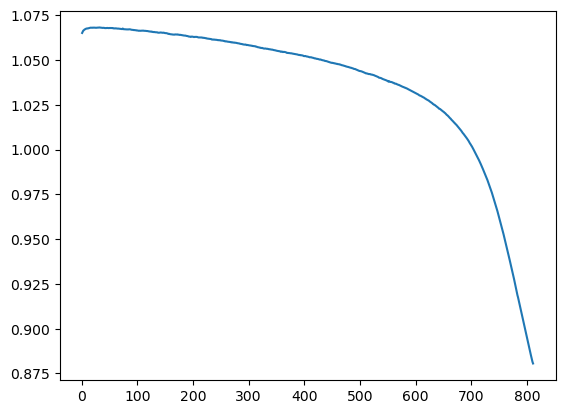

In [1282]:
bat = bat_dict['b3c20']

Y = 1-bat['summary']['QC'][1:]/1.1
length = len(bat['summary']['QD'][1:])
x = np.arange(1,length+1)
plt.plot(x,bat['summary']['QD'][1:])

In [1283]:
print(bat['cycle_life'])

[[813.]]


In [1284]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return np.exp(a)*x**b + c

param = curve_fit(func, x, Y, maxfev = 4000)[0]

alpha = param[0]
beta = param[1]
gamma = param[2]
print(gamma)

0.03703534717592715


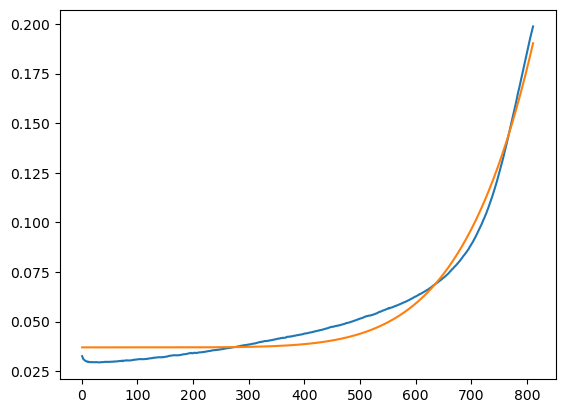

In [1267]:

#print(np.exp(alpha/temps)*np.power(x,beta) + gamma * np.log(x))
plt.plot(x, Y)
plt.plot(x, np.exp(alpha)*np.power(x,beta) +gamma)


In [1227]:
params = []
for i in bat_dict.keys():
    bat = bat_dict[i]
    Y = 1-bat['summary']['QC'][1:cutoff]/1.1
    length = len(bat['summary']['QD'][1:cutoff])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha, beta, gamma])
params = np.array(params)

In [1228]:
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.model_selection import *

data = np.loadtxt('./../Data/features4.csv',delimiter=',',skiprows=1) # skip row for column names

In [1229]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [1252]:
x_train = data[:,1:7][train_ind]
y_train = params[train_ind]

x_test = data[:,1:7][test_ind]
y_test = params[test_ind]

x_stest = data[:,1:7][secondary_ind]
y_stest = params[secondary_ind]

In [1253]:
print(x_test)

[[-5.01486104e+00 -2.07264797e+00 -2.07264797e+00 -2.74040637e-01
   1.29790365e-01  5.48000000e-05]
 [-4.73699974e+00 -1.76405786e+00 -1.76405786e+00  3.35018730e-02
  -4.57626750e-01  8.78000000e-06]
 [-4.64774366e+00 -1.85517696e+00 -1.85517696e+00 -4.40634335e-01
   1.25100669e-01  4.16000000e-05]
 [-3.76887790e+00 -1.42152079e+00 -1.42152079e+00 -3.89408127e-01
   9.27452330e-02  6.20000000e-05]
 [-4.05938368e+00 -1.54174789e+00 -1.54174789e+00 -3.68971416e-01
   7.26802490e-02 -3.76000000e-05]
 [-4.04606984e+00 -1.54830633e+00 -1.54830633e+00 -5.49054366e-01
   1.18359685e-01 -2.53000000e-05]
 [-4.09941368e+00 -1.55898590e+00 -1.55898590e+00 -9.10272068e-01
   8.92331660e-02 -1.72863000e-04]
 [-3.65008054e+00 -1.35523443e+00 -1.35523443e+00 -1.28333827e+00
   1.29215481e-01 -3.78000000e-05]
 [-3.36723741e+00 -1.19667656e+00 -1.19667656e+00 -6.16772288e-01
   3.04867920e-02  3.62000000e-06]
 [-4.04079364e+00 -1.52355218e+00 -1.52355218e+00 -8.44134617e-01
   9.01189770e-02 -1.5139

In [1254]:
print(x_train)

[[-5.01395962e+00 -1.95845666e+00 -1.95845666e+00 -3.67163344e-01
   1.24643310e-02 -1.57280000e-04]
 [-4.44261336e+00 -1.72214930e+00 -1.72214930e+00 -3.57485561e-01
   3.95790200e-02  1.82040000e-04]
 [-4.17887796e+00 -1.59896533e+00 -1.59896533e+00 -8.25794342e-01
   8.90308840e-02  2.37111000e-04]
 [-3.81348608e+00 -1.41755723e+00 -1.41755723e+00 -4.77012756e-01
   4.94257770e-02 -2.34385000e-04]
 [-4.14689653e+00 -1.62540720e+00 -1.62540720e+00 -2.25594077e-01
   8.11871970e-02 -3.53000000e-06]
 [-4.01794910e+00 -1.53843313e+00 -1.53843313e+00 -3.16954268e-01
   9.70684100e-02 -1.88699000e-04]
 [-3.97015945e+00 -1.50768716e+00 -1.50768716e+00 -5.91780484e-01
   1.10826083e-01 -4.39000000e-05]
 [-3.61990683e+00 -1.33825645e+00 -1.33825645e+00 -5.63163903e-01
   1.05651445e-01 -1.51000000e-06]
 [-3.35033805e+00 -1.18895973e+00 -1.18895973e+00 -1.04495406e+00
   5.80775110e-02 -3.98000000e-05]
 [-3.93866252e+00 -1.49699783e+00 -1.49699783e+00 -4.69975711e-01
   1.05233575e-01 -1.9815

[ 587  836  627  850  761  685  704  664  576  953  894  755  765  669
  933  716 1046  632 1132  723  592  338  456  945  756  363  590  573
  611  531  744  535  900  744  620  662  835  650  640  635  677  598
 1119]
[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519.  499.
  535.  465.  499.  466.  457.  429.  713.]
382.6205540376693


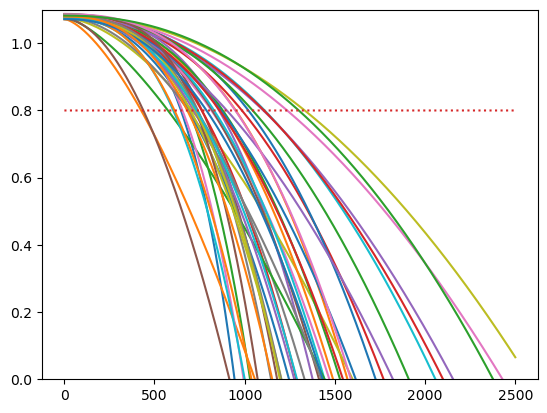

In [1268]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.neural_network import MLPRegressor

regr = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=10000, random_state=0)).fit(x_train, y_train)

predicted = regr.predict(x_test)
x=np.arange(1, 2500)
cycle_lives = []
for p in predicted:
    plt.plot(x, 1.1*(1 - (np.exp(p[0])*np.power(x,p[1]) + p[2])))
    predicted_array = 1.1*(1 - (np.exp(p[0])*np.power(x,p[1]) + p[2]))
    cycle_life = np.sum(predicted_array > 0.8*1.1)
    cycle_lives.append(cycle_life)
plt.plot(x, 0.8*np.ones(len(x)), ":")
plt.ylim(0, 1.1)

cycle_lives = np.array(cycle_lives)
truths = data[:, 0][test_ind]
print(cycle_lives)
print(truths)
rmse = np.sqrt(np.mean(np.abs(truths-cycle_lives)**2))
print(rmse)